In [23]:
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor 
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
import numpy as np
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from sklearn import linear_model
import statsmodels.formula.api as smf
import warnings
import numpy as np
from scipy import stats
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss
from sklearn import discriminant_analysis, neighbors
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

warnings.simplefilter(action='ignore', category=FutureWarning)

colors = ["cornflowerblue", "indianred", "darkseagreen", "plum", "dimgray"]

In [24]:
def calibracion(predicciones, y, bins):
    df_calibracion = pd.DataFrame({
        'predicciones':predicciones,
        'y':y
    })
    df_calibracion['bins'] = pd.qcut(df_calibracion['predicciones'], q=bins, labels=False, duplicates='drop') + 1
    grouped = df_calibracion.groupby('bins').mean()
    auc = roc_auc_score(y_score=predicciones, y_true=y)
    
    # Gráfica
    plt.figure(figsize=(7,5))
    plt.plot(grouped['predicciones'], grouped['predicciones'], label='Real', color='red', lw=1.5)
    plt.plot(grouped['predicciones'], grouped['y'], label='Modelo', marker='o', color='cadetblue', ms=5, lw=2)
    plt.title(f'Calibración del modelo \n\n$AUC={auc:.4f}$', fontsize=16, fontweight='bold')
    plt.grid(alpha=0.3)
    plt.legend()
    

# Gráfica de scatterplots
def scatterplots(data, target, numeric_features):
    num_vars = len(numeric_features) 

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    fig.tight_layout(pad=5)
    fig.suptitle('Scatterplots', fontsize=20, fontweight='bold', y=1)

    for i, ax in enumerate(axes.flat):
        if i < num_vars:
            ax.scatter(data[numeric_features[i]], data[target], marker='o', color='cadetblue', s=10, alpha=0.05)
            ax.set_title(f'{numeric_features[i]} vs {target}', fontsize=12, fontweight='bold')
            ax.set_xlabel(numeric_features[i])
            ax.set_ylabel(target)
            ax.grid(alpha=0.3, ls='--')
        else:
            ax.remove()

    plt.show()


# Gráfica de análsisi bivariado
def bivariado(data, target, numeric_features):
    num_vars = len(numeric_features)

    df_bivariado = data.copy()

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    fig.tight_layout(pad=5)
    fig.suptitle('Análisis Bivariado', fontsize=20, fontweight='bold', y=1)

    for i, ax in enumerate(axes.flat):
        if i < num_vars:
            df_bivariado[f'{numeric_features[i]}_bins'] = pd.qcut(df_bivariado[numeric_features[i]], q=10, labels=False, duplicates='drop') + 1
            grouped_data = df_bivariado.groupby(f'{numeric_features[i]}_bins').mean()
                
            ax.plot(grouped_data[numeric_features[i]], grouped_data[target], marker='o', color='cadetblue', lw=1, markersize=4)
            ax.set_title(numeric_features[i], fontsize=12, fontweight='bold')
            ax.set_xlabel(numeric_features[i])
            ax.set_ylabel(target)
            ax.grid(alpha=0.3, ls='--')
        else:
            ax.remove() # Eliminar subplots vacíos
            
    plt.show()


# Histogramas de frecuencia
def histogramas(data, numeric_features):
    num_vars = len(numeric_features)
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    fig.tight_layout(pad=3)
    fig.suptitle('Histogramas de Frecuencia', fontsize=20, fontweight='bold', y=1)


    for i, ax in enumerate(axes.flat):
        if i < num_vars:
            sns.histplot(data[numeric_features[i]],  color="cadetblue", kde=True, ax=ax, bins=30,  edgecolor=None)
            ax.set_title(numeric_features[i], fontsize=12, fontweight='bold')
            ax.grid(alpha=0.3)
        else:
            ax.remove() # Eliminar subplots vacíos


    plt.show()


def graph_knn(X_train, X_test, y_train, y_test, n_neighbors):
    vecinos = []
    auc = []

    # Escalado de datos
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    for i in range(1, n_neighbors+1):
        model = neighbors.KNeighborsClassifier(n_neighbors=i).fit(X_train_scaled, y_train)
        probabilidades = model.predict_proba(X_test_scaled)[:,1]
        vecinos.append(i)
        auc.append(roc_auc_score(y_score=probabilidades, y_true=y_test))

    resultados = pd.DataFrame({'nn':vecinos, 'auc': auc})
    max_auc = resultados[resultados['auc'] == resultados.max()['auc']][['nn', 'auc']]

    plt.figure(figsize=(7, 5))
    plt.title(f'Número de vecinos óptimo = {max_auc["nn"].values[0]:.0f}', fontsize=16, fontweight='bold')
    plt.plot(resultados['nn'], resultados['auc'], color='cadetblue',lw=1.5, marker='o', ms=3, label='Otros Puntos')
    plt.scatter(max_auc['nn'], max_auc['auc'], marker='*', color='red',zorder=2, s=50, label='Max AUC')
    plt.grid(alpha=0.3, ls='--')
    plt.ylabel('AUC')
    plt.xlabel('Número de Vecinos')
    plt.legend(loc='best')
    plt.show()


# Histograma
def histograma(probabilidades, y):
    resultados = pd.DataFrame({'y':y, 'probabilidades': probabilidades})
    plt.figure(figsize=(7,5))
    sns.histplot(resultados[resultados['y'] == 0]['probabilidades'], color='seagreen', alpha=0.5, kde=True, bins=20, edgecolor=None, label='0')
    sns.histplot(resultados[resultados['y'] == 1]['probabilidades'], color='cadetblue', alpha=0.5, kde=True, bins=20, edgecolor=None, label='1')
    plt.title('Histograma de probabilidades', fontsize=16, fontweight='bold')
    plt.legend(loc='best')
    plt.xlabel('Probabilidades')
    plt.ylabel('Frecuencia')
    plt.grid(alpha=0.3)
    plt.show()


# ROC Curve
def roc_curve_graph(probabilidades, y):
    fpr, fpn, scores = roc_curve(y_score=probabilidades, y_true=y)
    plt.figure(figsize=(7,5))
    plt.title('ROC Curve', fontsize=16, fontweight='bold')
    plt.plot(fpr, fpn, label='Modelo', color='cadetblue', lw=2)
    plt.plot([0, 1], [0, 1], label='Real', color='red', lw=1.5)
    plt.xlabel("1-specificty")
    plt.ylabel("sensitivity")
    plt.legend(loc='best')
    plt.grid(alpha=0.3)


# Plotear resultados
def plot_results(probabilidades, y, bins):
    calibracion(probabilidades, y, bins)
    histograma(probabilidades, y)
    roc_curve_graph(probabilidades, y)

In [25]:
def guardar_resultado(nombre_modelo, auc, lista_modelos, lista_auc):
    lista_modelos.append(nombre_modelo)
    lista_auc.append(auc)

# Ajustar modelo KNN
def knn_classifier(X_train, X_test, y_train, y_test, n_neighbors_opt):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = neighbors.KNeighborsClassifier(n_neighbors_opt).fit(X_train_scaled, y_train)
    probabilidades_knn = model.predict_proba(X_test_scaled)[:,1]
    auc = roc_auc_score(y_score=probabilidades_knn, y_true=y_test)
    return probabilidades_knn, auc


# Ajustar regresión logística
def logistic(X_train, y_train, X_test, y_test, degree):
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('poly_features', PolynomialFeatures(degree=degree, include_bias=False)),
        ('model', linear_model.LogisticRegression(penalty='l2'))
    ])

    pipeline.fit(X_train, y_train)
    probabilidades_logistic_poly = pipeline.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_score=probabilidades_logistic_poly, y_true=y_test)
    coef = pipeline.named_steps['model'].coef_
    return probabilidades_logistic_poly, auc, coef


# Ajustar modelo de discriminante lineal
def discriminante(X_train, y_train, X_test, y_test):
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', discriminant_analysis.LinearDiscriminantAnalysis())
    ])
    pipeline.fit(X_train, y_train)
    probabilidades_modelo_disc = pipeline.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_score=probabilidades_modelo_disc, y_true=y_test)
    return probabilidades_modelo_disc, auc


# Ajustar modelo de red neuronal
def neural_network(X_train, X_test, y_train, y_test):
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures()),
        ('nn', MLPRegressor())
    ])
    params_grid = {
        'poly__degree': [1, 2],
        'nn__hidden_layer_sizes': [(5, 5, 5), (10, 10, 10), (20, 20, 20), (50, 50), (100, )],
        'nn__activation': ['tanh', 'relu', 'logistic'],
        'nn__alpha': [0.1, 0.01]
    }
    grid_search = GridSearchCV(pipeline, param_grid=params_grid, cv=5, scoring='roc_auc', n_jobs=-1).fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    probabilidades = best_model.predict(X_test)
    auc = roc_auc_score(y_score=probabilidades, y_true=y_test)
    return probabilidades, auc


In [26]:
data = pd.read_csv('hr_role.csv')
data.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,is_satisfied
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,...,80,0,8,0,1,6,4,0,5,True
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,...,80,1,10,3,3,10,7,1,7,False
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,...,80,0,7,3,3,0,0,0,0,False
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,...,80,0,8,3,3,8,7,3,0,False
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,...,80,1,6,3,3,2,2,2,2,False


In [27]:
data = pd.get_dummies(data)

target = 'is_satisfied'
X = data.drop(target, axis=1)
y = data[target]

numeric_features = [col for col in X.columns if X[col].dtype in ['float64']]
categorical_features = [col for col in X.columns if X[col].dtype not in ['float64']]

In [28]:
scatterplots(data, target, numeric_features)

<Figure size 1200x500 with 0 Axes>

In [29]:
bivariado(data, target, numeric_features)

<Figure size 1200x500 with 0 Axes>

In [30]:
histogramas(data, numeric_features)

<Figure size 1200x500 with 0 Axes>

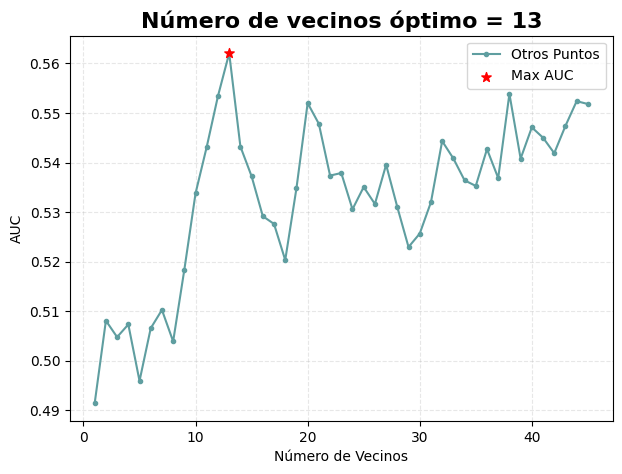

In [31]:
X = data.drop(target, axis=1)
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

graph_knn(X_train, X_test, y_train, y_test, 45)